# Import Libraries

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
from pandas.plotting import scatter_matrix
import sys
from sklearn import preprocessing

% matplotlib inline

print('Python version', sys.version)
print('Pandas version', pd.__version__)
print('Numpy version', np.__version__)

Python version 3.6.3 |Anaconda, Inc.| (default, Oct  6 2017, 12:04:38) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
Pandas version 0.20.3
Numpy version 1.14.0


In [6]:
schools_and_crime_budget = data = pd.read_pickle('../data/cleaned_data.pkl')
schools_and_crime = pd.read_pickle('../data/schools_crimes.pkl')

In [7]:
data = schools_and_crime_budget
data.head()

,School_ID,Graduation_Rate_School,Short_Name,School_Type,Student_Count_Total,Student_Count_Low_Income,Transportation_El,School_Latitude,School_Longitude,Average_ACT_School,crimes_per_student,dollars_per_student,percent_diff_budget,percent_low_income
0,609678,91.8,JONES HS,Selective enrollment,1866,732,"Blue, Brown, Pink, Red",41.873066,-87.627675,26.2,0.041801,5928.036977,-0.020497,NaN
1,400056,82.4,NOBLE - ROWE CLARK HS,Charter,474,441,"Blue, Brown, Green",41.895362,-87.718047,18.5,0.702532,9852.668776,0.011480,NaN
2,610244,85.8,CLARK HS,Magnet,548,512,"Blue, Green",41.872885,-87.753325,16.3,0.122263,8522.198905,0.011480,NaN
3,400058,67.1,NORTH LAWNDALE - CHRISTIANA HS,Charter,357,349,Green,41.858564,-87.708987,15.3,0.641457,5184.064426,-0.181877,NaN
4,400059,69.7,NORTH LAWNDALE - COLLINS HS,Charter,351,340,Red,41.864146,-87.700681,14.5,0.150997,5272.680912,-0.181877,NaN


## Plot Graduation Rates by Crime and School

# Add Features

## Add Percent Low Income Feature

In [8]:
data['percent_low_income'] = [low_income/all_students for (all_students, low_income) 
                                     in zip(data['Student_Count_Total'], 
                                            data['Student_Count_Low_Income'])]

data.loc[:10, ['Student_Count_Total', 'Student_Count_Low_Income', 'percent_low_income']]

,Student_Count_Total,Student_Count_Low_Income,percent_low_income
0,1866,732,0.392283
1,474,441,0.930380
2,548,512,0.934307
3,357,349,0.977591
4,351,340,0.968661
5,276,263,0.952899
6,245,229,0.934694
7,313,295,0.942492
8,113,105,0.929204
9,598,492,0.822742


## Add School Type Feature

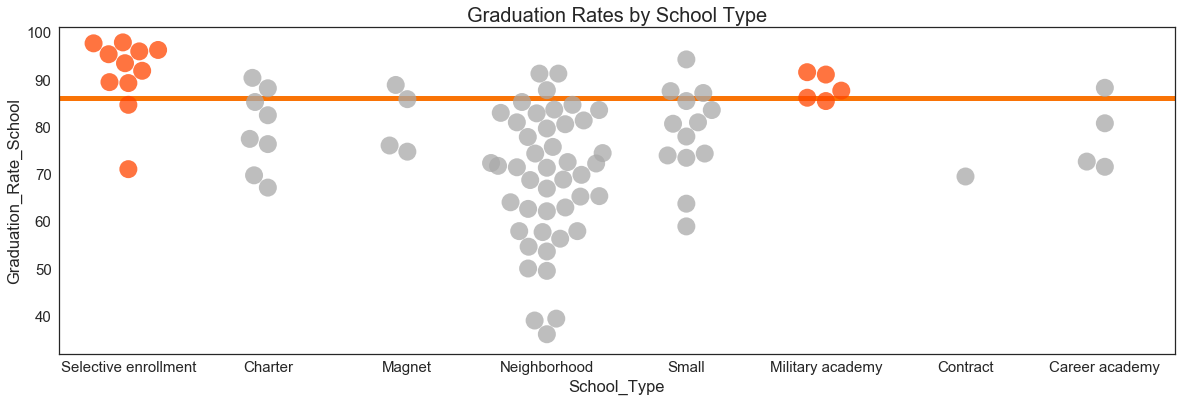

In [118]:
sns.set(font_scale=1.5)
sns.set_style("white")
fig, ax = plt.subplots(figsize=(20,6))

top_quartile = data['Graduation_Rate_School'].quantile(.75)

palette = ["#ff4500", "#a9a9a9", "#a9a9a9", "#a9a9a9", "#a9a9a9", "#ff4500", '#a9a9a9', '#a9a9a9']
sns.swarmplot(x="School_Type", y="Graduation_Rate_School", palette = palette,
              data=data, size=18, alpha=.75)
ax.set_title('Graduation Rates by School Type', size=20);

x = plt.gca().axes.get_xlim()
plt.plot(x, len(x) * [top_quartile], sns.xkcd_rgb["orange"], linewidth=5)
plt.show();


A couple observations about the plot above:
> **1)** The school type **Selective Enrollment** and **Military** schools seem to be characterized by a high graduation rate (with one exception), but other types seem to fall across a broader spectrum of graduation rates

> **2)** There also seems to be a graduation rate outlier we don't need - the **Citywide-Option** school seems to have a graduation rate close to 0

## 1) Add Selective Enrollment Variable
Let's create a new variable to indicate if the school is a Selective Enrollment School instead of blowing out our feature matrix with dummy variables for all school types

In [84]:
data['is_selective_enroll'] = [1 if (x == 'Selective enrollment') | (x == 'Military academy') 
                               else 0 for x in data['School_Type']]

## Remove Unnecessary Columns

In [85]:
list(data)

['School_ID',
 'Graduation_Rate_School',
 'Short_Name',
 'School_Type',
 'Transportation_El',
 'School_Latitude',
 'School_Longitude',
 'Average_ACT_School',
 'crimes_per_student',
 'dollars_per_student',
 'percent_diff_budget',
 'percent_low_income',
 'is_selective_enroll']

In [86]:
data = data.loc[:,['School_ID','Graduation_Rate_School', 'Short_Name', 'School_Type','Transportation_El',
                      'School_Latitude','School_Longitude','Average_ACT_School', 'crimes_per_student',
                      'dollars_per_student','percent_diff_budget', 'percent_low_income', 'is_selective_enroll']]

## 2) Remove Graduation Rate Outliers

In [87]:
data[['Short_Name', 'Graduation_Rate_School']].sort_values(by='Graduation_Rate_School').head(10)

,Short_Name,Graduation_Rate_School
29,HIRSCH HS,36.1
5,ORR HS,39.0
30,ROBESON HS,39.4
71,FENGER HS,49.5
25,TILDEN HS,50.0
35,HYDE PARK HS,53.6
61,HARLAN HS,54.6
31,DOUGLASS HS,56.3
13,MARSHALL HS,57.7
39,PHILLIPS HS,57.9


Hmm, that top school with the lowest graduation rate seem suspect...let's go ahead and apply a mask to drop the extreme outlier

In [88]:
data['Graduation_Rate_School'].describe()

count    90.000000
mean     76.070000
std      13.648628
min      36.100000
25%      68.975000
50%      77.600000
75%      86.025000
max      97.800000
Name: Graduation_Rate_School, dtype: float64

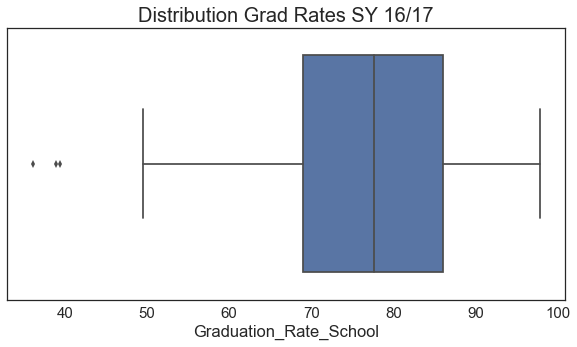

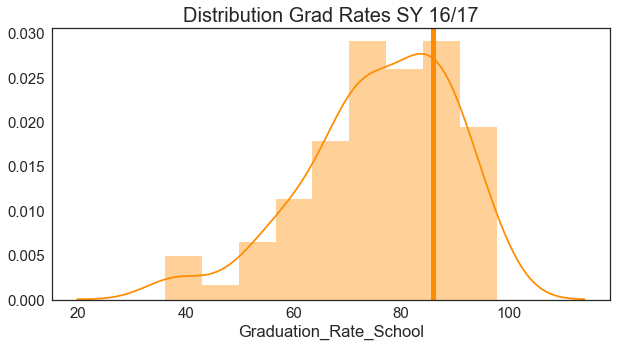

In [113]:
sns.set(font_scale=1.5)
sns.set_style("white")

fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(data['Graduation_Rate_School'])
ax.set_title('Distribution Grad Rates SY 16/17', size=20)
plt.show();

fig, ax = plt.subplots(figsize=(10,5))
sns.distplot(data['Graduation_Rate_School'], color='darkorange')
ax.set_title('Distribution Grad Rates SY 16/17', size=20)
plt.axvline(x=86, color='darkorange', linewidth=5)

plt.show();

In [90]:
def find_outliers(series, multiplier=1.5):
    """
    Takes as input a series, identifies the outliers as defined as 1.5 * IQR from the .75 Q and return a mask to identify them
    """
    adjusted_IQR = (series.quantile(.75) - series.quantile(.25)) * multiplier
    upper_lim = series.quantile(.75) + adjusted_IQR
    lower_lim = series.quantile(.25) - adjusted_IQR

    print('Upper Lim:', round(upper_lim, 2))
    print('Lower Lim:', round(lower_lim, 2))

    outliers = [True if (x > upper_lim) | (x < lower_lim) else False for x in series]
    
    outlier_count = sum(outliers)
    all_data_count = len(series)
    print('{} outliers identified: {} of all data'.format(outlier_count, round(outlier_count/all_data_count,6)))
    
    return outliers

In [91]:
outliers = find_outliers(data['Graduation_Rate_School'], multiplier=3)

Upper Lim: 137.17
Lower Lim: 17.83
0 outliers identified: 0.0 of all data


In [92]:
data.drop(data.index[outliers], inplace=True)

In [93]:
data[['Short_Name', 'Graduation_Rate_School']].sort_values(by='Graduation_Rate_School').head(5)

,Short_Name,Graduation_Rate_School
29,HIRSCH HS,36.1
5,ORR HS,39.0
30,ROBESON HS,39.4
71,FENGER HS,49.5
25,TILDEN HS,50.0


In [94]:
data.reset_index(inplace=True)

# Visualize Correlation

In [95]:
def get_target_feature_set(data):
    
    if (~data['dollars_per_student'].isnull()).sum():
        target_features = data.loc[:,['Graduation_Rate_School', 'Average_ACT_School', 'crimes_per_student',
                                      'dollars_per_student', 'percent_diff_budget', 'percent_low_income', 'is_selective_enroll']]
    else:
        target_features = data.loc[:,['Graduation_Rate_School', 'Average_ACT_School', 'crimes_per_student', 
                                      'percent_low_income', 'is_selective_enroll']]
                                   
    return target_features

In [96]:
target_features = get_target_feature_set(data)
corr = target_features.corr()

In [97]:
def fancy_corr(corr):
    cmap = cmap=sns.diverging_palette(5, 250, as_cmap=True)
    
    return corr.style.background_gradient(cmap, axis=1)\
            .set_properties(**{'max-width': '70px', 'font-size': '10pt'})\
            .set_precision(2)\

In [98]:
fancy_corr(corr)

,Graduation_Rate_School,Average_ACT_School,crimes_per_student,dollars_per_student,percent_diff_budget,percent_low_income,is_selective_enroll
Graduation_Rate_School,1,0.7,-0.51,-0.34,-0.0071,-0.45,0.49
Average_ACT_School,0.7,1,-0.44,-0.43,0.091,-0.83,0.63
crimes_per_student,-0.51,-0.44,1,0.56,0.0063,0.35,-0.15
dollars_per_student,-0.34,-0.43,0.56,1,0.17,0.34,-0.17
percent_diff_budget,-0.0071,0.091,0.0063,0.17,1,-0.11,0.024
percent_low_income,-0.45,-0.83,0.35,0.34,-0.11,1,-0.45
is_selective_enroll,0.49,0.63,-0.15,-0.17,0.024,-0.45,1


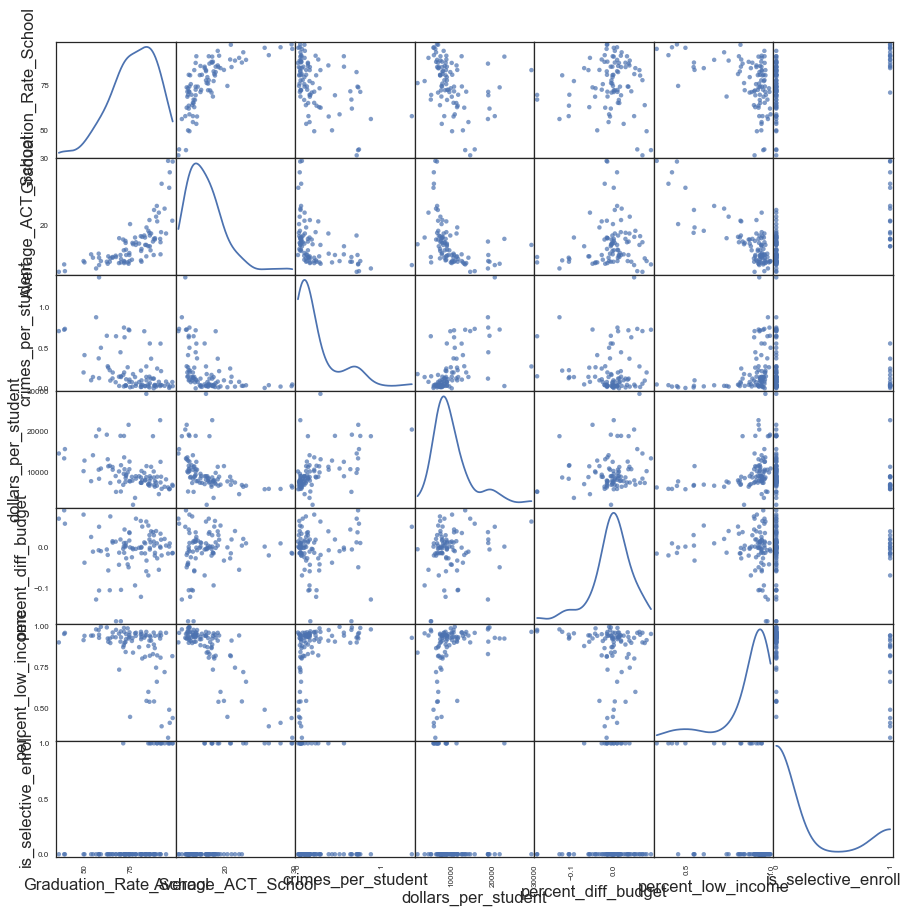

In [127]:
scatter_matrix(target_features, alpha=0.7, s=80, figsize=(15, 15), diagonal='kde');

Ok, so I'm going to take the log of:

- **Average ACT**

- **Crimes per Student**

- **Dollars per Student**

It looks like the **Percent Diff Budget** and **Percent Low Income** aren't very correlated to my target but maybe this will change after the data is on the same scale?

# Feature Transformation

Let's try exponentially transforming our **Average ACT**, **Crimes per Student**, **Dollars per Student** feature to capture more of the curve

In [133]:
target_features['Average_ACT_log'] = target_features["Average_ACT_School"].apply(np.log)
target_features['crimes_student_log'] = target_features["crimes_per_student"].apply(np.log)

try:
    target_features['dollars_student_log'] = target_features["dollars_per_student"].apply(np.log)
except KeyError:
    pass

target_features_transform = target_features.filter(['Graduation_Rate_School', 'Average_ACT_log', 'percent_low_income', 'crimes_student_log'], axis=1)


In [134]:
corr = target_features_transform.corr()
fancy_corr(corr)

,Graduation_Rate_School,Average_ACT_log,percent_low_income,crimes_student_log
Graduation_Rate_School,1,0.74,-0.45,-0.54
Average_ACT_log,0.74,1,-0.81,-0.56
percent_low_income,-0.45,-0.81,1,0.49
crimes_student_log,-0.54,-0.56,0.49,1


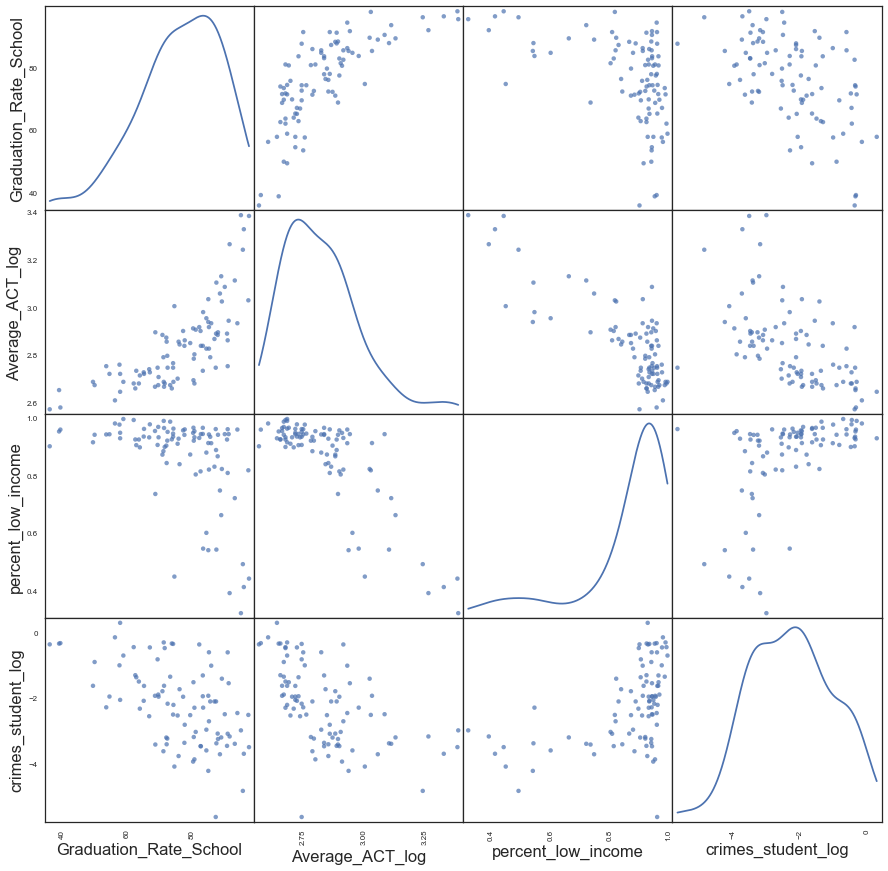

In [136]:
scatter_matrix(target_features_transform, alpha=0.7, s=80, figsize=(15, 15), diagonal='kde');

# Pickle Feature Data and Target

In [645]:
X = target_features.drop('Graduation_Rate_School', axis=1)
y = target_features['Graduation_Rate_School']

X.to_pickle('../data/feature_data.pkl')
y.to_pickle('../data/target_data.pkl')